本次实验要求我们从给定的数据中挖掘出所有最小函数依赖，数据在文件data.txt中，12个属性，共14970条记录。

我采取的算法为TANE/MEM算法，详细算法见下图：
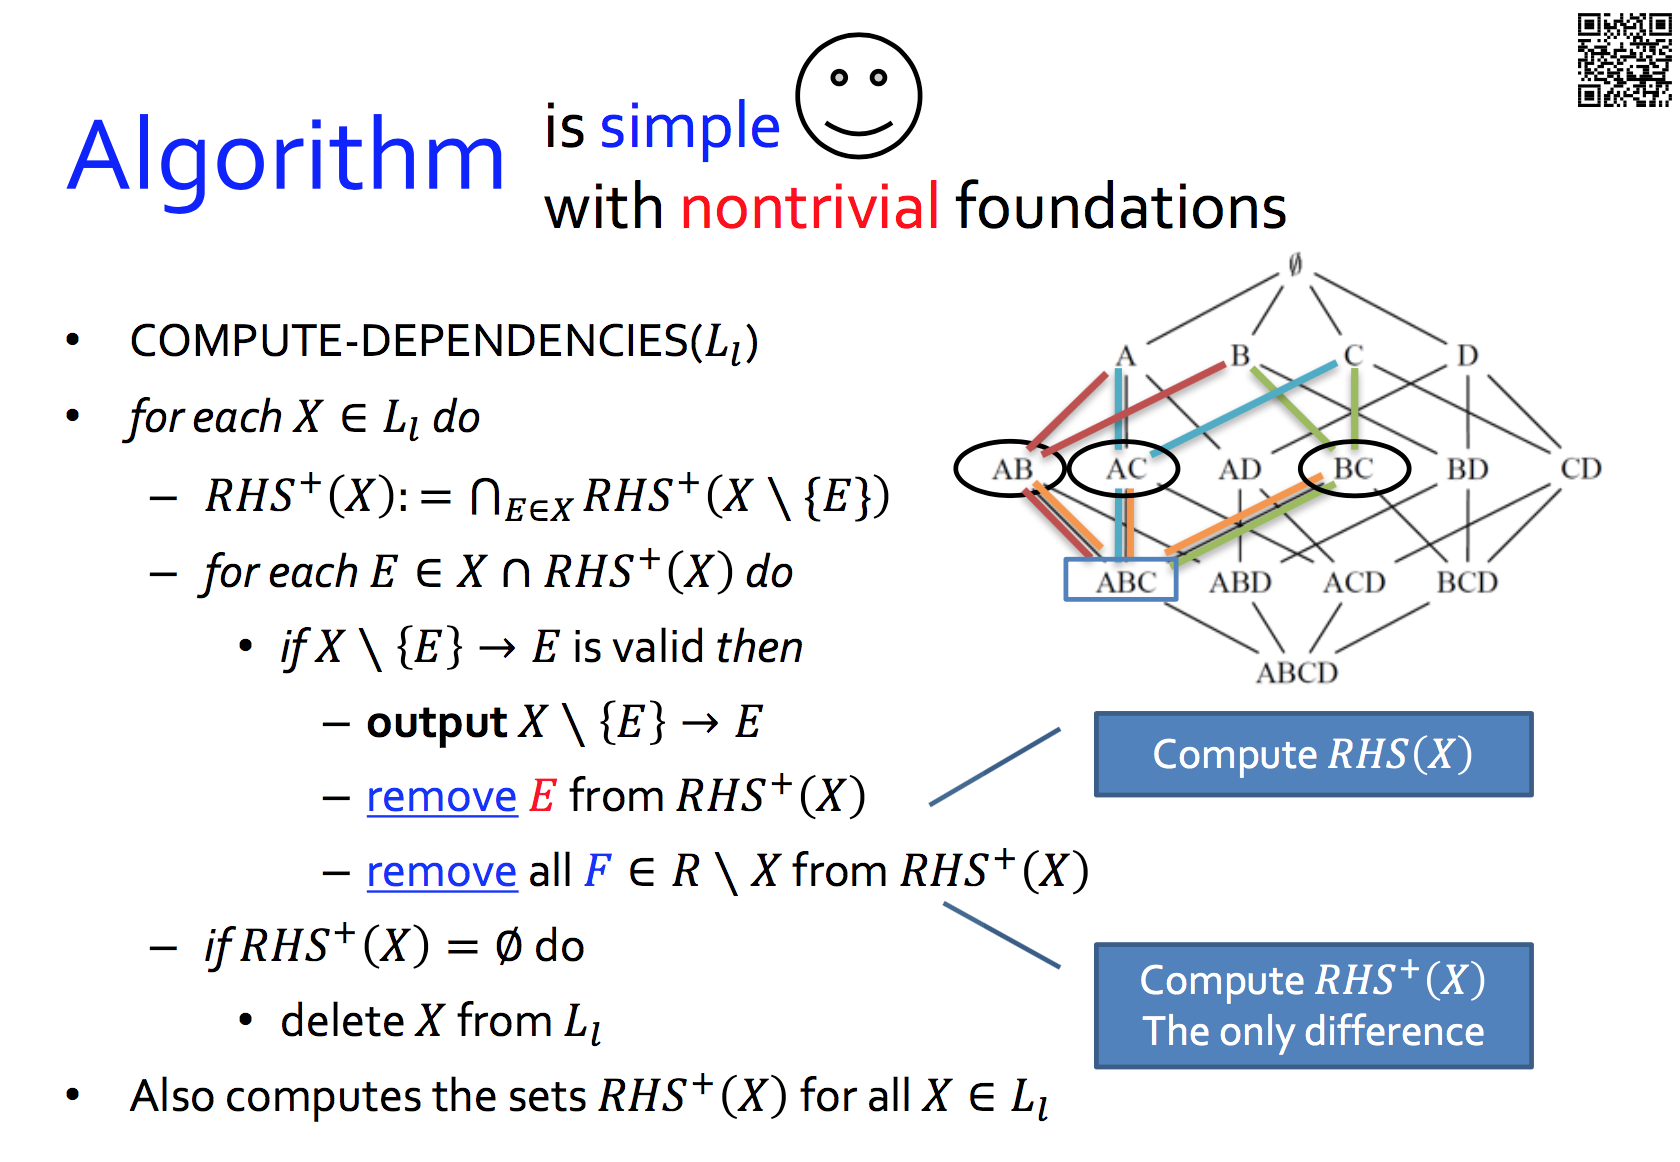

In [25]:
from __future__ import print_function
import numpy as np
import csv
import time
from datetime import datetime
from collections import defaultdict
t1 = datetime.now()

首先，我们需要定义一个函数来获得partition，这是TANE算法的核心所在。

在本次实验中，属性集（attributes）的类型为元素类型为number的集合（由于python中set不是hashable的，故使用frozenset来表示集合，下同），而partition使用集合的集合来表示。

在函数get_partition中，为了防止重复计算，因此采用记忆化搜索的方式，将结果储存在partitions中（partitions是一个从属性集到划分的一个map）。因此在函数头部首先检查是否已经计算过该值，若计算过则直接返回储存好的值，否则分类讨论：
* 属性集长度为0，则代表不使用任何属性来进行划分，因此返回空集。
* 属性集长度为1，则该属性将作为划分依据，使用一个map聚合在该划分依据下的等价类，这些等价类构成的集合即为所求的结果。
* 属性集长度大于等于2（设长度为l），可以利用之前的划分结果得到当前划分结果。具体实现方式为：
    1. 获得当前属性集的任意两个不同的长度为l-1的属性子集对应的那两个划分。
    2. 对这两个划分求积即为所需结果，详细过程见函数merge_partition。

In [26]:
partitions = {}
def getFrozenSetFromOne(x):
    return frozenset([x,])

def merge_partition(ps1, ps2):
    s = []
    iRow2p = {}
    for i, p1 in enumerate(ps1):
        for iRow in p1:
            iRow2p[iRow] = i
    for p2 in ps2:
        tmp = defaultdict(list)
        for iRow in p2:
            tmp[iRow2p[iRow]].append(iRow)
        s += tmp.values()
    return s

def get_partition(attributes):
    if attributes in partitions:
        return partitions[attributes]
    
    if len(attributes) == 0:
        partitions[attributes] = []
    elif len(attributes) == 1:
        iAttr = tuple(attributes)[0]
        d = defaultdict(list)
        for index, row in enumerate(table):
            d[row[iAttr]].append(index)
        partitions[attributes] = d.values()
    else:
        attr_tuple = tuple(attributes)
        ps1 = get_partition(frozenset(attr_tuple[0:-1]))
        ps2 = get_partition(frozenset(attr_tuple[0:-2] + attr_tuple[-1:]))
        partitions[attributes] = merge_partition(ps1, ps2)
        
    return partitions[attributes]


有了获得划分的函数，判定两个属性集之间是否存在函数依赖就变得简单了，只需判定这两个属性集对应的划分长度是否相同即可。详见函数`isValid`，该函数判定X-{E} -> E是否是一个合法的函数依赖。

In [27]:
def isValid(X, E): 
    '''
    test if X\{E} -> E is valid
    X is a set of number, E is a number
    '''
    return len(get_partition(X - {E})) == len(get_partition(X))

下面我们开始考虑每一层的计算，按照TANE算法的流程，对于$L_l$中的所有元素X，我们首先计算出$\cap_{E \in X} RHS^{+}(X - \{E\})$并将该集合赋给$RHS^{+}(X)$，然后遍历$X \cap RHS^{+}(X)$中的所有元素，判定$X - \{E\} \rightarrow E$ 是否是一个合法的函数依赖，若是，保存该函数依赖，从$RHS^{+}(X )$中去除E和$R - X$中的所有元素。最后判定$RHS^{+}(X )$是否是一个空集，若是，则从$L_l$中删除X即可。

算法实现见函数`compute_dependencies`，参数L即为$L_l$，L_new储存删除后的$L_l$。（这里需要注意的是在将L拷贝给L_new时，由于python中的直接赋值为浅拷贝，修改L_new会同步修改L，造成程序运行结果错误，因此应该使用L.copy()来进行深拷贝）

In [28]:
def compute_dependencies(L): # L is a set of tuple of number
    L_new = L.copy()
    for X in L:
        Xs = frozenset(X)
        RHS[X] = R
        for E in Xs:
            RHS[X] = RHS[X] & RHS[Xs - {E}]
        for E in RHS[X] & Xs:
            if isValid(Xs, E):
                fds.append((Xs - {E}, E))
                RHS[X] -= getFrozenSetFromOne(E)
                RHS[X] = RHS[X] & Xs
        if len(RHS[X]) == 0:
            L_new.remove(X)
    
    return L_new

下面的函数赋值由上一层的candidate key生成下一层的candidate key。

In [29]:
def generate_next_level(L):
    # list comprehension?
    Ln = set([])
    for l1 in L:
        for l2 in L:
            if l1 != l2 and len(l1 - l2) == 1:
                Ln.add(l1 | l2)
    return Ln

由于结果要求按照字典序进行排序，因此需要自定义排序函数，首先按照函数依赖的左边进行排序，在左边相同的情况下按照右边进行排序。

结果输出部分较为简单，对结果进行自定义排序后按照题目要求的格式输出到文件即可。

In [30]:
def mycmp(fd1, fd2):
    left1 = sorted(list(fd1[0]))
    left2 = sorted(list(fd2[0]))
    if left1 < left2 or (fd1[0] == fd2[0] and fd1[1] < fd2[1]):
        return -1
    elif left1 > left2 or (fd1[0] == fd2[0] and fd1[1] > fd2[1]):
        return 1
    else:
        return 0

def output_fd(fds):
    with open(output_filename, 'w') as f:
        fds_sorted = sorted(fds, cmp=mycmp)
        for fd in fds_sorted:
            str = ''
            for l in sorted(list(fd[0])):
                str += '%d ' % (l+1)
            str += '-> %d\n' % (fd[1]+1)
            f.write(str)
            # print(str, end='')

有了上面的铺垫，函数主体部分就比较简单了，首先读入文件，然后从第1层开始逐层计算函数依赖，最后输出结果即可。具体实现详见下面的代码：

In [31]:
# get data
input_filename = 'data.txt'
output_filename = 'outputp.txt'
with open(input_filename, 'rb') as f:
    reader = csv.reader(f)
    table = map(tuple, reader)

maxL = len(table[0])
R = frozenset(range(maxL))
RHS = {frozenset([]): R}
fds = []
 
L = frozenset(map(getFrozenSetFromOne, R))
L = compute_dependencies(L)
for i in range(1, maxL):
    L = compute_dependencies(generate_next_level(L))
    print('level: %d, time used: %s' %(i+1, datetime.now() - t1))

output_fd(fds)

level: 2, time used: 0:00:07.504743
level: 3, time used: 0:00:13.684483
level: 4, time used: 0:00:29.408593
level: 5, time used: 0:00:39.931784
level: 6, time used: 0:00:42.548781
level: 7, time used: 0:00:42.550652
level: 8, time used: 0:00:42.550925
level: 9, time used: 0:00:42.551150
level: 10, time used: 0:00:42.551279
level: 11, time used: 0:00:42.551358
level: 12, time used: 0:00:42.551474


下面是一些与函数依赖挖掘无关的啰嗦。

我的第一版实现花了一个半小时才跑出所有结果，经过一早上的优化，终于可以在40s左右跑完了。在调试过程中，我体会到了jupyter notebook的强大，只需要一句%prun即可测试出整段python代码的运行时间分布，大大方便了我找出瓶颈。下面是我在优化过程中做的一个实验，我定义了4个函数，这4个函数的目的都是一样的，返回一个元素类型为frozenset的frozenset（由于set是unhashable的，不能作为map的键，也不能作为set的元素。而frozenset是hashable的，故本次试验大量使用了frozenset）。

第一个函数直接通过frozenset的或运算来实现，第二个通过list[tuple]来实现，第三个通过list[list]来实现，最后转化成目标格式，第四个通过set[set]来实现。

从运行时间来看，这四种方式的运行时间逐渐降低，最快的方法比最慢的方法快了100余倍。直接使用frozenset效率低下有如下两个原因：
1. frozenset是不可变的，当需要修改其内容时需要重新分配空间，故时间效率很低。
2. 由于元素天生是不重复的（每次插入c时c的值都会增加1，保证了c的不重复），故每次将c插入cur时检查cur中是否有元素与c是否重复是多余的。
而set，list是可变的，当发生大量修改时效率较高。

而我的第一版程序使用的就是最慢的方法。

In [34]:
n = 15000
m = 12
def get_frozenset():
    c = 0
    s1 = frozenset([])
    for i in range(n):
        cur = frozenset([])
        for j in range(m):
            c += 1
            cur |= frozenset([c])
        s1 |= frozenset([cur])
    return s1
  
def get_tuple():
    c = 0
    s1 = []
    for i in range(n):
        cur = ()
        for j in range(m):
            c += 1
            cur += (c,)
        s1.append(cur)
    s1 = frozenset(map(frozenset, s1))
    return s1

def get_list():
    c = 0
    s1 = []
    for i in range(n):
        cur = []
        for j in range(m):
            c += 1
            cur.append(c)
        s1.append(cur)
    s1 = frozenset(map(frozenset, s1))
    return s1

def get_set():
    c = 0
    s1 = set([])
    for i in range(n):
        cur = set([])
        for j in range(m):
            c += 1
            cur.add(c)
        s1.add(frozenset(cur))
    return frozenset(s1)

assert(get_frozenset() == get_list_set() and get_list_set() == get_list() and get_list() == get_set())

%timeit get_frozenset()
%timeit get_list_set()
%timeit get_list()
%timeit get_set()

1 loop, best of 3: 7.6 s per loop
10 loops, best of 3: 147 ms per loop
10 loops, best of 3: 94.4 ms per loop
10 loops, best of 3: 66.5 ms per loop
